In [1]:
#Bibliothek für die Sonneneinstrahlung
!pip install pvlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 19.4 MB/s eta 0:00:00


In [2]:
#Bibliothek mit den Wetterdaten
!pip install meteostat

In [3]:
# Datenorganisation
import pandas as pd
import numpy as np
import datetime as dt
import pickle

# Ploterstellung
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib widget
import seaborn as sns

# Tensorflow
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Bidirectional, Dropout,Flatten, Concatenate)
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)
import tensorflow as tf

In [4]:
from datetime import datetime
from meteostat import Point
from meteostat import Hourly

In [5]:
# Hole die Sonneneinstrahlung viertelstundenscharf im vorgegebenen Zeitraum
# Einstellung des Zeitraums
start = datetime(2018, 1, 1)
end = datetime(2024, 4, 3)

# Koordinanten vom Standort Lebach, saarland
place = Point(49.375346, 6.92742)
meteo = Hourly(place, start, end)
meteo = meteo.fetch()
meteo = meteo.asfreq(freq='15T', method='ffill') #Extrapolation von Stunden auf Viertelstunden

In [6]:
meteo

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2018-01-01 00:00:00,7.9,4.3,78.0,0.0,NaN,250.0,43.2,NaN,1005.3,NaN,NaN
2018-01-01 00:15:00,7.9,4.3,78.0,0.0,NaN,250.0,43.2,NaN,1005.3,NaN,NaN
2018-01-01 00:30:00,7.9,4.3,78.0,0.0,NaN,250.0,43.2,NaN,1005.3,NaN,NaN
2018-01-01 00:45:00,7.9,4.3,78.0,0.0,NaN,250.0,43.2,NaN,1005.3,NaN,NaN
2018-01-01 01:00:00,7.8,3.6,75.0,0.0,NaN,250.0,39.6,NaN,1006.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02 23:00:00,6.2,5.2,93.0,0.0,0.0,167.0,9.7,14.0,1011.8,0.0,3.0
2024-04-02 23:15:00,6.2,5.2,93.0,0.0,0.0,167.0,9.7,14.0,1011.8,0.0,3.0
2024-04-02 23:30:00,6.2,5.2,93.0,0.0,0.0,167.0,9.7,14.0,1011.8,0.0,3.0


In [8]:
# Sonneneinstrahlung
from pvlib import location

datum = pd.date_range(start=start, end=end, freq='15T')
site = location.Location(49.375346, 6.92742)

# Berechnng der Sonneneinstrahlung
Sonneneinstrahlung = site.get_clearsky(datum)
Sonneneinstrahlung

,ghi,dni,dhi
2018-01-01 00:00:00,0.0,0.0,0.0
2018-01-01 00:15:00,0.0,0.0,0.0
2018-01-01 00:30:00,0.0,0.0,0.0
2018-01-01 00:45:00,0.0,0.0,0.0
2018-01-01 01:00:00,0.0,0.0,0.0
...,...,...,...
2024-04-02 23:00:00,0.0,0.0,0.0
2024-04-02 23:15:00,0.0,0.0,0.0
2024-04-02 23:30:00,0.0,0.0,0.0
2024-04-02 23:45:00,0.0,0.0,0.0


In [9]:
# Zusammenführung aller Features
Features = pd.concat([Sonneneinstrahlung, meteo], axis=1)
Features = Features.drop(columns=['snow','wspd','wpgt','tsun','coco'], axis=0)
Features

,ghi,dni,dhi,temp,dwpt,rhum,prcp,wdir,pres
2018-01-01 00:00:00,0.0,0.0,0.0,7.9,4.3,78.0,0.0,250.0,1005.3
2018-01-01 00:15:00,0.0,0.0,0.0,7.9,4.3,78.0,0.0,250.0,1005.3
2018-01-01 00:30:00,0.0,0.0,0.0,7.9,4.3,78.0,0.0,250.0,1005.3
2018-01-01 00:45:00,0.0,0.0,0.0,7.9,4.3,78.0,0.0,250.0,1005.3
2018-01-01 01:00:00,0.0,0.0,0.0,7.8,3.6,75.0,0.0,250.0,1006.0
...,...,...,...,...,...,...,...,...,...
2024-04-02 23:00:00,0.0,0.0,0.0,6.2,5.2,93.0,0.0,167.0,1011.8
2024-04-02 23:15:00,0.0,0.0,0.0,6.2,5.2,93.0,0.0,167.0,1011.8
2024-04-02 23:30:00,0.0,0.0,0.0,6.2,5.2,93.0,0.0,167.0,1011.8
2024-04-02 23:45:00,0.0,0.0,0.0,6.2,5.2,93.0,0.0,167.0,1011.8


# **Deskriptive Analyse der Features**

In [10]:
Features.describe()

,ghi,dni,dhi,temp,dwpt,rhum,prcp,wdir,pres
count,219265.000000,219265.000000,219265.000000,219265.000000,219265.000000,219265.000000,219265.000000,219265.000000,219265.000000
mean,179.116199,266.767113,39.497504,10.769711,5.893334,75.176316,0.113941,172.161526,1016.802027
std,255.788320,317.277398,49.820193,7.717146,5.901175,18.970199,0.560172,97.544363,9.252736
min,0.000000,0.000000,0.000000,-11.900000,-18.100000,15.000000,0.000000,0.000000,975.700000
25%,0.000000,0.000000,0.000000,4.900000,1.900000,61.000000,0.000000,70.000000,1011.800000
50%,0.050763,0.360812,0.047712,10.000000,6.100000,80.000000,0.000000,203.000000,1017.200000
75%,318.261211,621.755211,81.450503,16.400000,10.200000,91.000000,0.000000,251.000000,1022.500000
max,865.969867,816.557647,148.919729,36.500000,23.000000,100.000000,28.200000,360.000000,1047.400000



1.   ghi: Globale horizontale Strahlung
2.   dni: Direkte normale Strahlung
3.   dhi: Diffuse horizontale Strahlung
4.   temp:Remperaturen
5.   dwpt:Taupunkt
6.   rhum:Relative Feuchtigkeit
7.   prcp:Gesamtniederschlagshöhe
8.   wdir:Windrichtung
9.   pres:Luftdruck





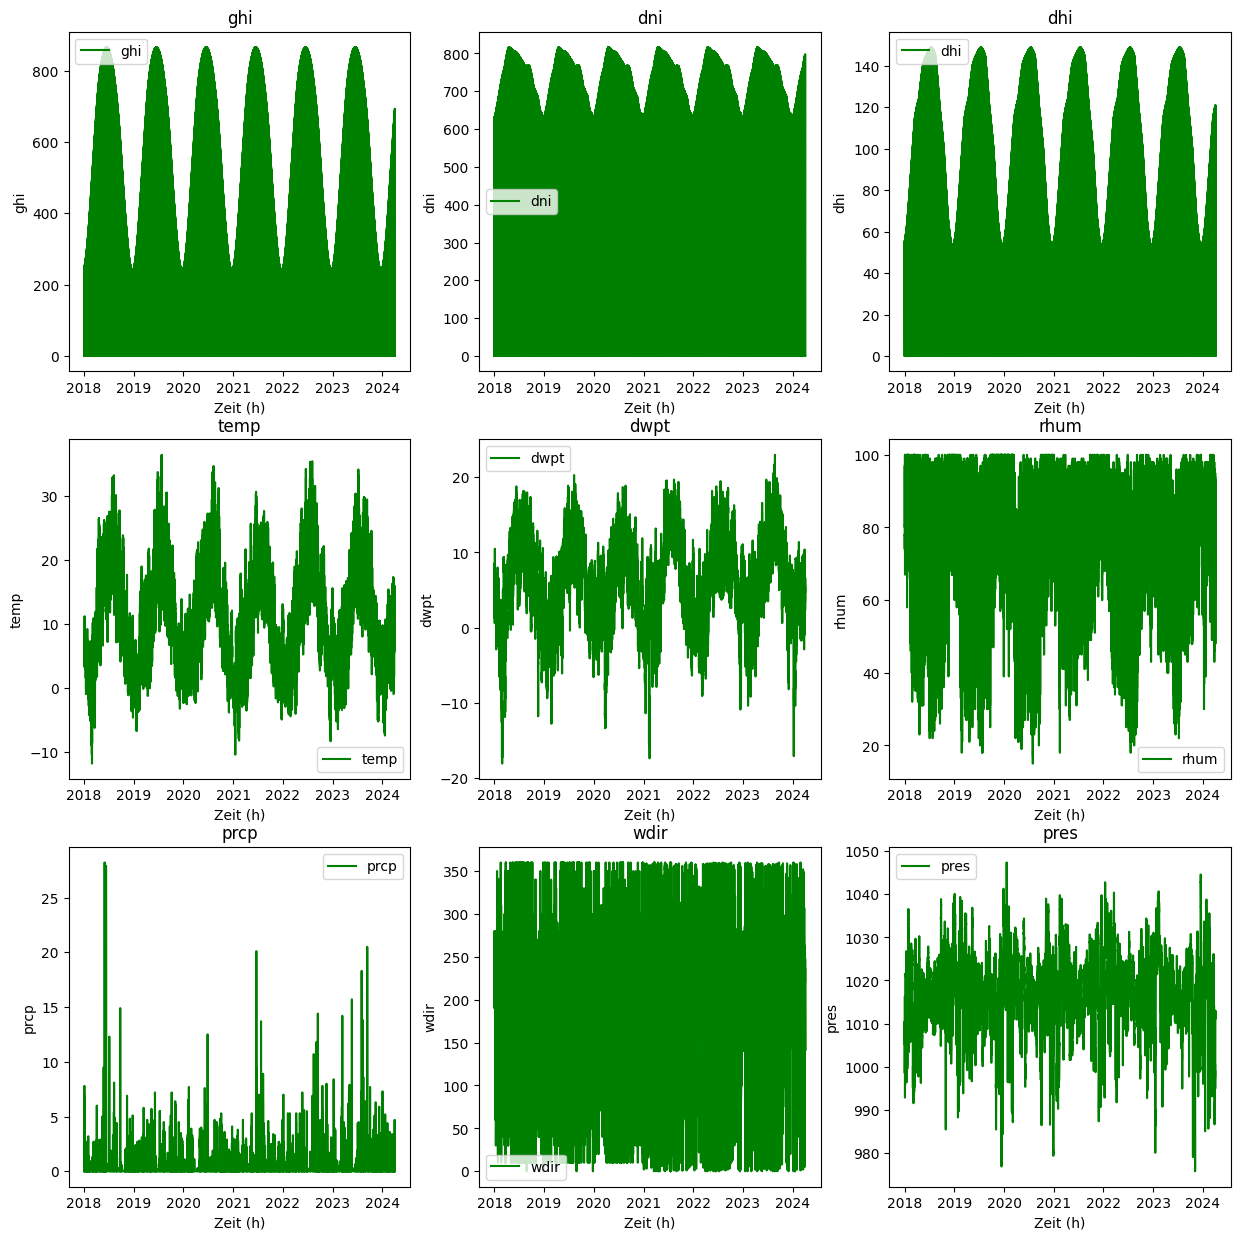

In [11]:
# Einfache Darstellung der Kenngrößen
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(Features.iloc[:,i], label=Features.columns[i],color="green")
    plt.legend()
    plt.xlabel('Zeit (h)')
    plt.ylabel(Features.columns[i])
    plt.title(Features.columns[i])

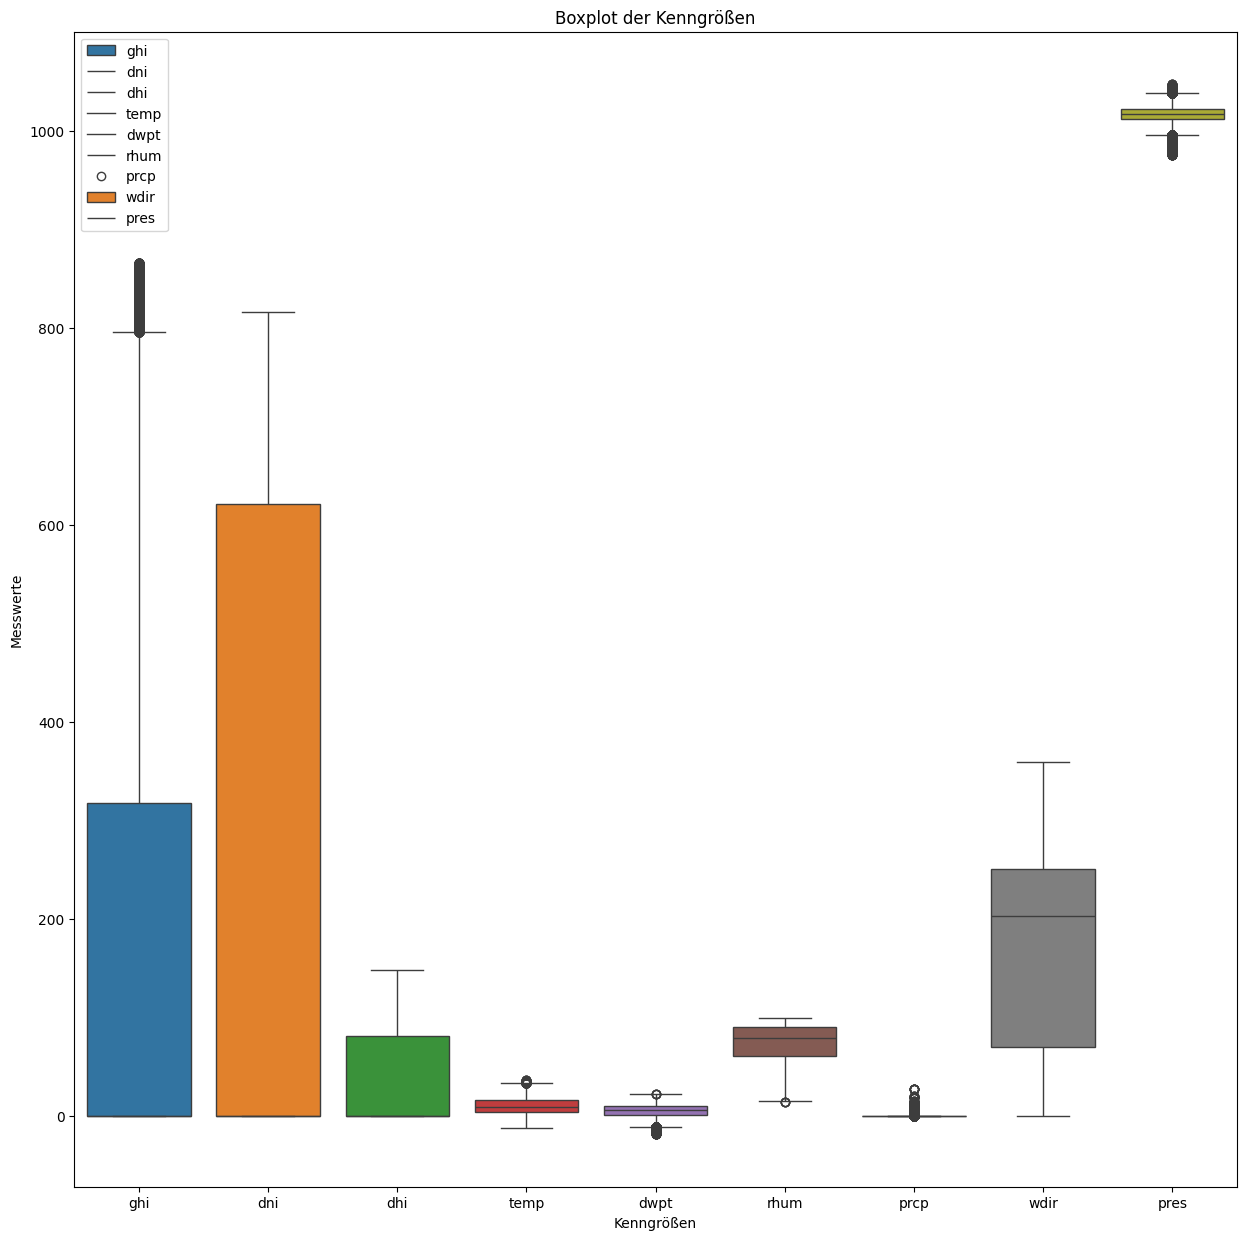

In [12]:
# Boxplot der Kenngrößen
plt.figure(figsize=(15,15))
sns.boxplot(Features)
plt.xlabel('Kenngrößen')
plt.ylabel('Messwerte')
plt.title('Boxplot der Kenngrößen')
plt.legend(Features.columns[0:9])

In [13]:
# Ausreißerberinigung mit der Z-score Methode
for i in range(9):
    Oberlimit = Features.iloc[:,i].mean() + 3*Features.iloc[:,i].std()
    Unterlimit = Features.iloc[:,i].mean() - 3*Features.iloc[:,i].std()
    outliers = Features.loc[(Features.iloc[:,i]<Oberlimit) & (Features.iloc[:,i]>Unterlimit)]
    # Kappen der Ausreißer mit Ober- oder Unterlimitswerte
    Features.iloc[:,i][(Features.iloc[:,i]>Oberlimit)] = Oberlimit
    Features.iloc[:,i][(Features.iloc[:,i]<Unterlimit)] = Unterlimit
    print(Features.columns[i] +' hat ' + np.str_(len(Features)-len(outliers)) + ' bereinigete Ausreißer')

ghi hat 0 bereinigete Ausreißer
dni hat 0 bereinigete Ausreißer
dhi hat 0 bereinigete Ausreißer
temp hat 136 bereinigete Ausreißer
dwpt hat 1088 bereinigete Ausreißer
rhum hat 76 bereinigete Ausreißer
prcp hat 3684 bereinigete Ausreißer
wdir hat 0 bereinigete Ausreißer
pres hat 1468 bereinigete Ausreißer


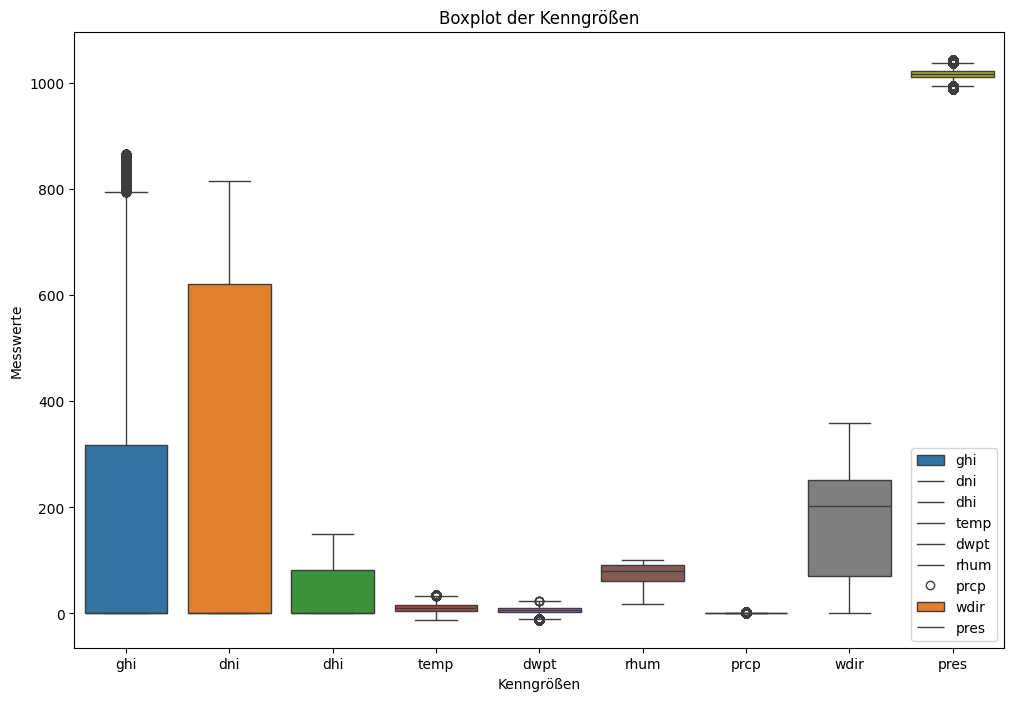

In [14]:
#Capping by changing the outliers in upper or lower limit
plt.figure(figsize=(12,8))
sns.boxplot(Features)
plt.xlabel('Kenngrößen')
plt.ylabel('Messwerte')
plt.title('Boxplot der Kenngrößen')
plt.legend(Features.columns[0:9])

# **Korrelationsmatrix**

In [15]:
#Einteilen der Daten in Trainings- und Testdaten
Erzeuger = pd.read_pickle('/content/Erzeugung.pkl')
Erzeuger_train = Erzeuger['Messwerte'][Erzeuger.index <= '2024-04-02 23:45']
Erzeuger_train = pd.DataFrame(Erzeuger_train)
Erzeuger_train

,Messwerte
2018-01-01 00:00:00,0.0
2018-01-01 00:15:00,0.0
2018-01-01 00:30:00,0.0
2018-01-01 00:45:00,0.0
2018-01-01 01:00:00,0.0
...,...
2024-04-02 22:45:00,0.0
2024-04-02 23:00:00,0.0
2024-04-02 23:15:00,0.0
2024-04-02 23:30:00,0.0


In [16]:
Erzeuger_test = Erzeuger['Messwerte'][Erzeuger.index > '2024-04-02 23:45']
Erzeuger_test = pd.DataFrame(Erzeuger_test)
Erzeuger_test

,Messwerte
2024-04-03 00:00:00,0.0
2024-04-03 00:15:00,0.0
2024-04-03 00:30:00,0.0
2024-04-03 00:45:00,0.0
2024-04-03 01:00:00,0.0
...,...
2024-04-04 21:30:00,0.0
2024-04-04 21:45:00,0.0
2024-04-04 22:00:00,0.0
2024-04-04 22:15:00,0.0


In [17]:
# Features und Messwerte für die Korrelation concatenaten
corr = pd.concat([Erzeuger_train, Features], axis=1)
corr = corr.fillna(0)
corr

,Messwerte,ghi,dni,dhi,temp,dwpt,rhum,prcp,wdir,pres
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,7.9,4.3,78.0,0.0,250.0,1005.3
2018-01-01 00:15:00,0.0,0.0,0.0,0.0,7.9,4.3,78.0,0.0,250.0,1005.3
2018-01-01 00:30:00,0.0,0.0,0.0,0.0,7.9,4.3,78.0,0.0,250.0,1005.3
2018-01-01 00:45:00,0.0,0.0,0.0,0.0,7.9,4.3,78.0,0.0,250.0,1005.3
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,7.8,3.6,75.0,0.0,250.0,1006.0
...,...,...,...,...,...,...,...,...,...,...
2024-04-02 23:00:00,0.0,0.0,0.0,0.0,6.2,5.2,93.0,0.0,167.0,1011.8
2024-04-02 23:15:00,0.0,0.0,0.0,0.0,6.2,5.2,93.0,0.0,167.0,1011.8
2024-04-02 23:30:00,0.0,0.0,0.0,0.0,6.2,5.2,93.0,0.0,167.0,1011.8
2024-04-02 23:45:00,0.0,0.0,0.0,0.0,6.2,5.2,93.0,0.0,167.0,1011.8


In [18]:
# import plotly.graph_objects as go
# fig = go.Figure()
# x = Erzeuger.index
# fig.add_trace(go.Scatter(
#     x=x,
#     y=Own_feature['differenz'],
#     name = 'Diff',
#     connectgaps=True,
#     line=dict(color='green')
#     ))
# fig.add_trace(go.Scatter(
#     x=x,
#     y=Feature['ghi_diff'],
#     name = 'ghi_diff',
#     connectgaps=True,
#     line=dict(color='blue')
#     ))
# fig.add_trace(go.Scatter(
#     x=x,
#     y=clearsky['ghi'],
#     name = 'ghi',
#     connectgaps=True,
#     line=dict(color='black')
#     ))
# fig.add_trace(go.Scatter(
#     x=x,
#     y=Erzeuger['Messwerte'],
#     name = 'Messwerte',
#     connectgaps=True,
#     line=dict(color='purple')
#     ))
# # fig.add_trace(go.Scatter(
# #     x=x,
# #     y=clearsky_dataframe['clearsky_index'],
# #     name = 'clearsky_index',
# #     connectgaps=True,
# #     line=dict(color='brown')
# #     ))
# fig.update_layout(title='Features/ target',
#                    xaxis_title='Zeitschritte viertelstündlich (h)',
#                    yaxis_title='Einheit')
# fig.show()

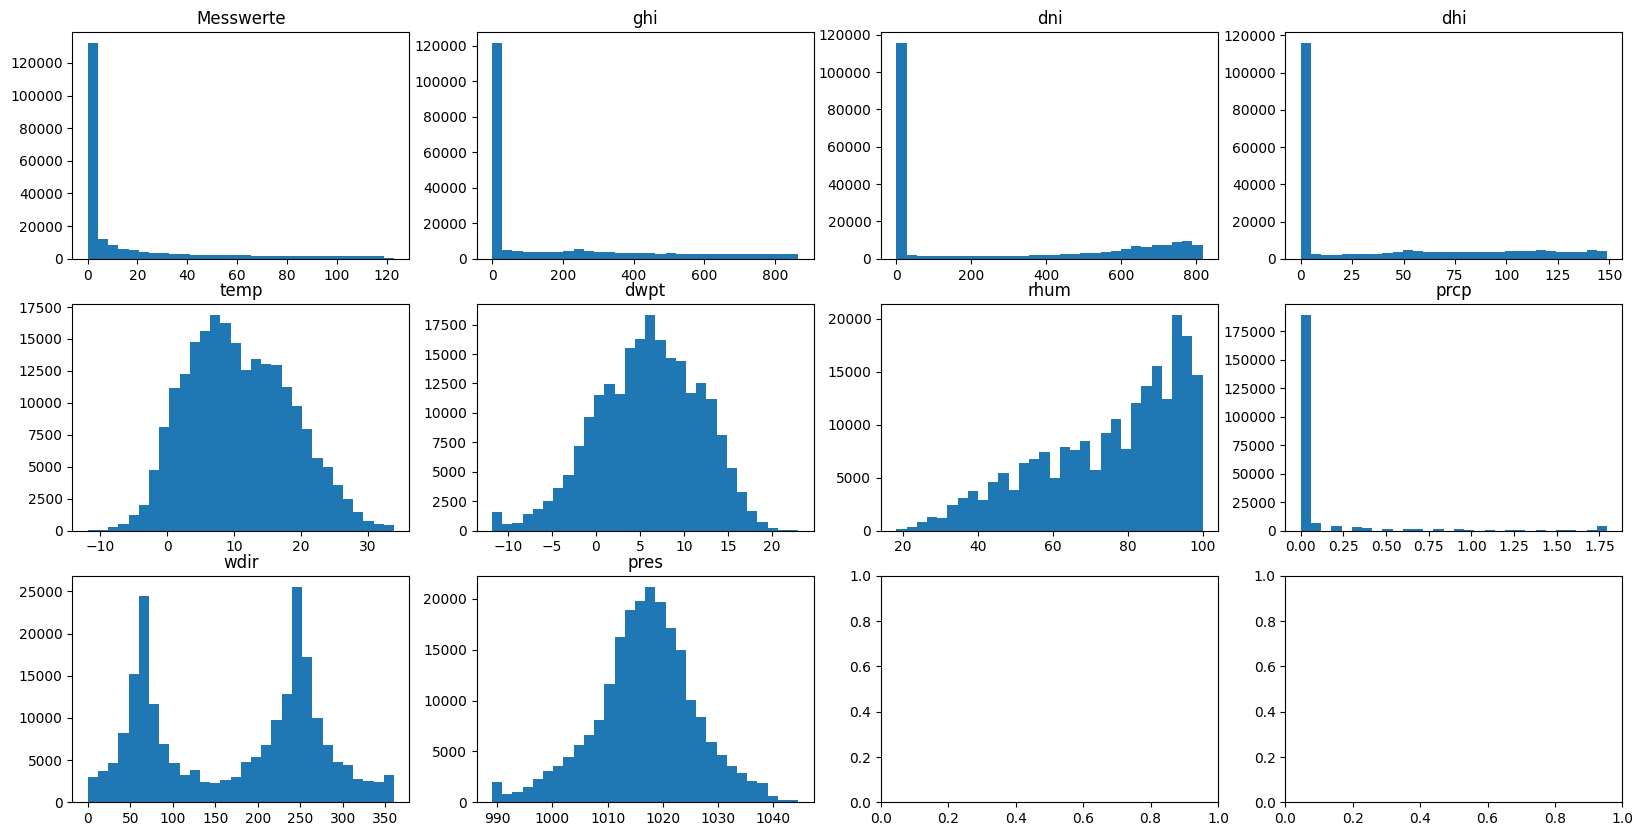

In [19]:
fig, axs = plt.subplots(3, 4, figsize=(20,10))
axs = axs.ravel()
for i, column in enumerate(corr.columns):
  axs[i].hist(corr[column], bins=30)
  axs[i].set_title(column)

plt.show()

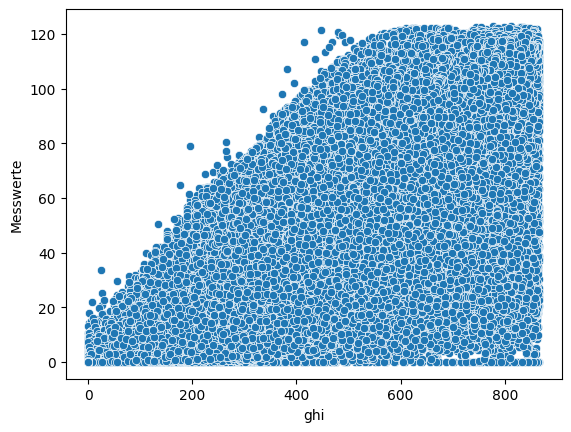

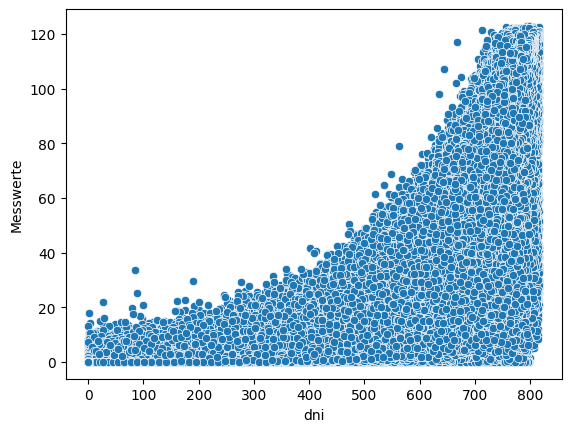

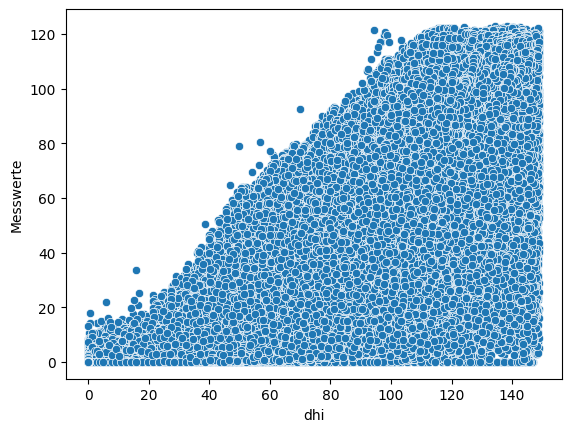

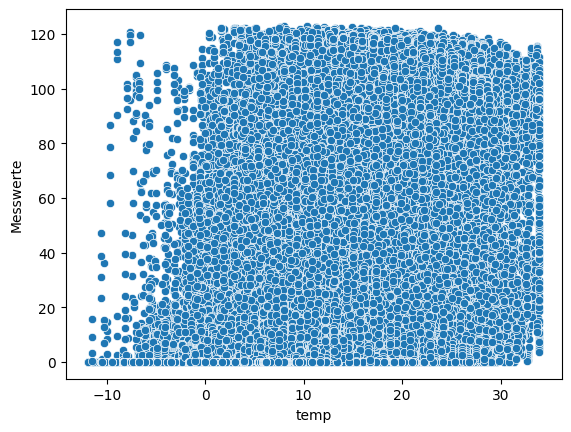

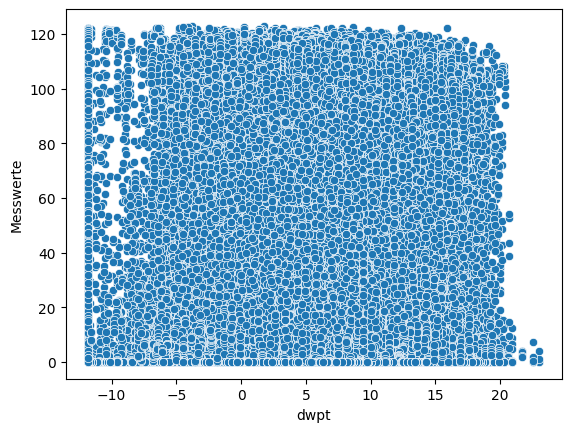

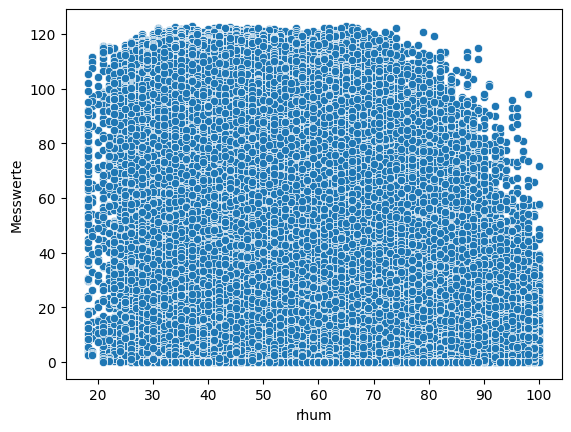

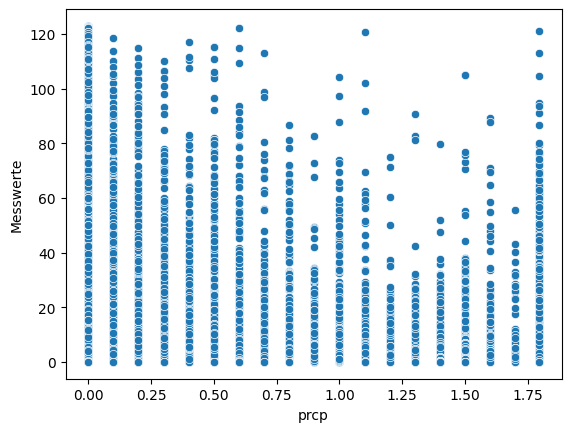

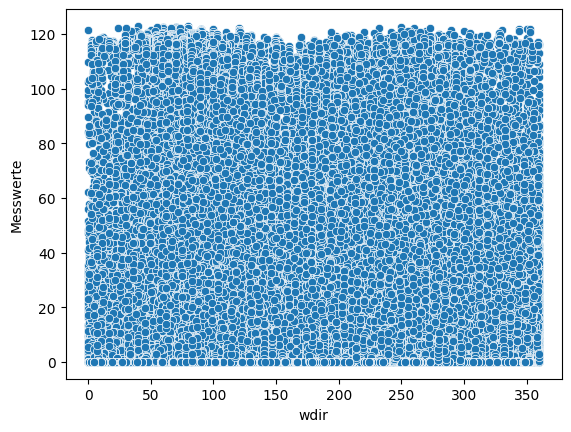

In [20]:
for i in range(1,9):
  sns.scatterplot(x=corr.iloc[:,i], y=corr.iloc[:,0])

  plt.show()

Text(0.5, 1.0, 'Korrelationsmatrix der Kenn- und Messgrößen')

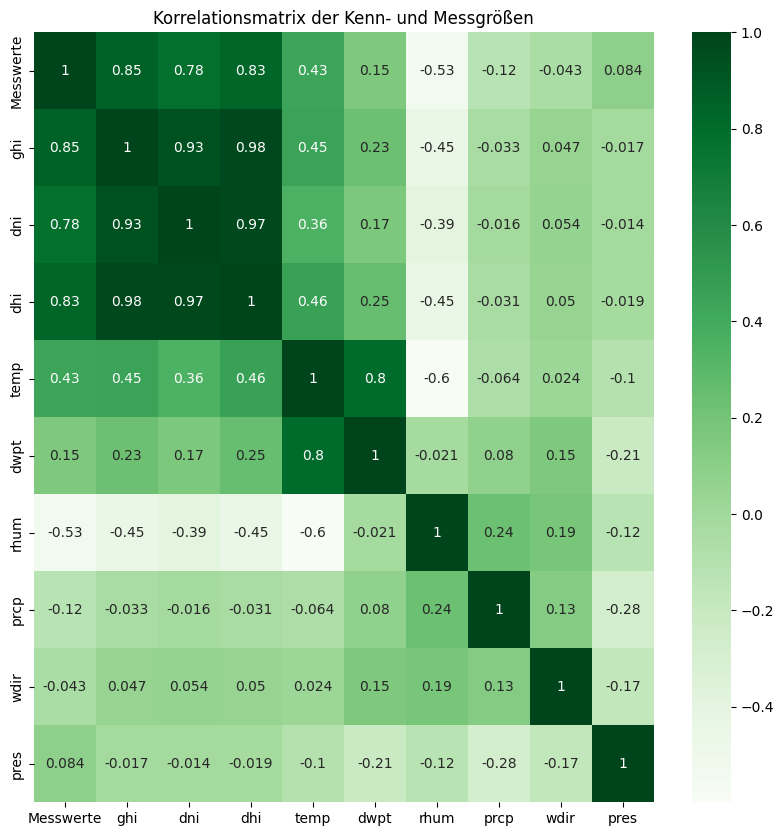

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(corr.corr(), cmap="Greens", annot=True)
#sns.heatmap(Features)
plt.title('Korrelationsmatrix der Kenn- und Messgrößen')

Die Messwerte sind mit ghi, dni und dhi am meisten korreliert, da die Features sich auf die Sonneneinstrahlugn beziehen, wird nur die globale Sonneeinstrahlung weiter betrachtet. Die Features temp und rhum werden kommen auch dazu. Dies ergibt drei wesentliche Features für das neuronale Netz: ghi, temp und rhum

# **Prognose auf Basis der ausgewählten Features**

In [22]:
new_features = corr.drop(columns=['Messwerte','dni','dhi','dwpt','prcp','wdir','pres'], axis=0)
new_features = new_features.iloc[:-1,:]
new_features

,ghi,temp,rhum
2018-01-01 00:00:00,0.0,7.9,78.0
2018-01-01 00:15:00,0.0,7.9,78.0
2018-01-01 00:30:00,0.0,7.9,78.0
2018-01-01 00:45:00,0.0,7.9,78.0
2018-01-01 01:00:00,0.0,7.8,75.0
...,...,...,...
2024-04-02 22:45:00,0.0,6.6,93.0
2024-04-02 23:00:00,0.0,6.2,93.0
2024-04-02 23:15:00,0.0,6.2,93.0
2024-04-02 23:30:00,0.0,6.2,93.0


In [27]:
#Trainings- und Validierungsdatensatz trennen
x_feat_train = new_features.iloc[:200000]
x_feat_val = new_features.iloc[200000:]
x_feat_val

,ghi,temp,rhum
2023-09-15 08:00:00,365.017438,17.0,68.0
2023-09-15 08:15:00,401.786657,17.0,68.0
2023-09-15 08:30:00,436.681547,17.0,68.0
2023-09-15 08:45:00,469.481102,17.0,68.0
2023-09-15 09:00:00,499.990341,19.1,63.0
...,...,...,...
2024-04-02 22:45:00,0.000000,6.6,93.0
2024-04-02 23:00:00,0.000000,6.2,93.0
2024-04-02 23:15:00,0.000000,6.2,93.0
2024-04-02 23:30:00,0.000000,6.2,93.0


In [28]:
#Trainings- und Validierungsdatensatz trennen
y_train = Erzeuger_train.iloc[:200000]
y_val = Erzeuger_train.iloc[200000:]
y_val

,Messwerte
2023-09-15 08:00:00,63.02
2023-09-15 08:15:00,71.78
2023-09-15 08:30:00,77.94
2023-09-15 08:45:00,82.66
2023-09-15 09:00:00,87.56
...,...
2024-04-02 22:45:00,0.00
2024-04-02 23:00:00,0.00
2024-04-02 23:15:00,0.00
2024-04-02 23:30:00,0.00


Aufbau des neuronalen Netzes

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.losses import mean_absolute_error, mean_squared_error

# Modelldefinition
model = Sequential([
    Dense(64, activation='relu', input_shape=[3]),
    Dense(32, activation='relu'),
    Dense(1)
])

# Modell kompilieren
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

#Callback
checkpoint_path = r"/content/best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Modell trainieren mit Validierungsdaten
history = model.fit(x_feat_train, y_train, epochs=50, batch_size=32, validation_data=(x_feat_val, y_val), callbacks=checkpoint)

# Modell evaluieren
loss, mae = model.evaluate(x_feat_val, y_val)
print("Validation Mean Absolute Error:", mae)


Epoch 1/50
6246/6250 [============================>.] - ETA: 0s - loss: 247.6362 - mae: 8.2918
Epoch 1: val_loss improved from inf to 129.29387, saving model to /content/best_model.h5
6250/6250 [==============================] - 20s 3ms/step - loss: 247.6110 - mae: 8.2913 - val_loss: 129.2939 - val_mae: 5.2966
Epoch 2/50
  63/6250 [..............................] - ETA: 15s - loss: 242.3317 - mae: 8.4625

6245/6250 [============================>.] - ETA: 0s - loss: 225.8926 - mae: 7.8680
Epoch 2: val_loss improved from 129.29387 to 126.58770, saving model to /content/best_model.h5
6250/6250 [==============================] - 18s 3ms/step - loss: 225.8597 - mae: 7.8680 - val_loss: 126.5877 - val_mae: 5.4366
Epoch 3/50
6242/6250 [============================>.] - ETA: 0s - loss: 213.5581 - mae: 7.6601
Epoch 3: val_loss improved from 126.58770 to 114.92741, saving model to /content/best_model.h5
6250/6250 [==============================] - 18s 3ms/step - loss: 213.5792 - mae: 7.6601 - val_loss: 114.9274 - val_mae: 5.4480
Epoch 4/50
6246/6250 [============================>.] - ETA: 0s - loss: 199.8730 - mae: 7.3420
Epoch 4: val_loss improved from 114.92741 to 111.51870, saving model to /content/best_model.h5
6250/6250 [==============================] - 19s 3ms/step - loss: 199.8846 - mae: 7.3421 - val_loss: 111.5187 - val_mae: 4.9343
Epoch 5/50
6245/6250 [============================>.] - E

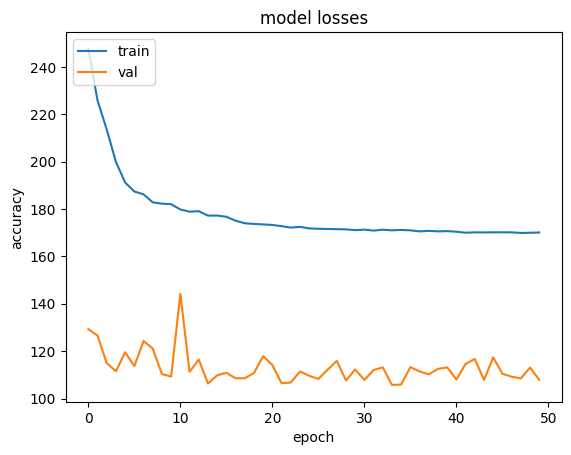

In [42]:
# Verluste
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model losses')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

3/3 [==============================] - 0s 3ms/step


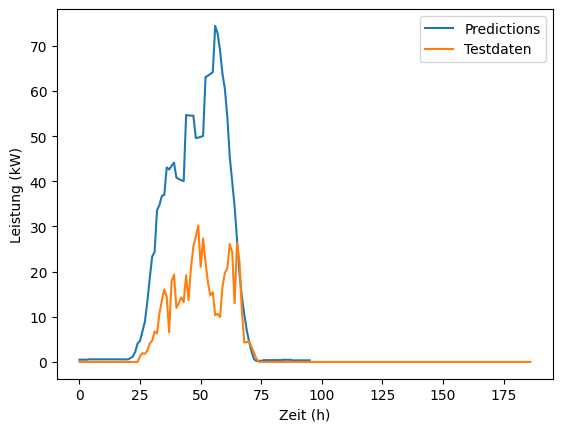

In [43]:
# Prognose nur der nächsten Einspeisung
prediction = model.predict(x_feat_val[-96:])
plt.plot(prediction)
plt.plot(Erzeuger_test.to_numpy()) #np.array([Erzeuger_test]))
plt.xlabel('Zeit (h)')
plt.ylabel('Leistung (kW)')
plt.legend(['Predictions','Testdaten'])
plt.show()